# **Segmentación del riesgo LAFT**
**Parte 2**

**Presentado por _Luis Hernando Benitez_**

#Limpieza y Exploracion de relaciones -  Clustering riesgo LAFT

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
#--------------visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly
sns.set_theme('notebook')
sns.set_palette("Set2")
#------------------------

## 1. Carga de datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UNAL/DiplomadoML/modulo 2 - Introduc a ML con Python/U6 - Proyecto aplicado/Data/DATA_SET_LUIS.csv")

In [ ]:
df

,ID,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,Row2,Servicios,9499,Medio Alto,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
1,Row3,Servicios,9499,Medio Alto,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28
2,Row5,Servicios,9499,Medio Alto,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50
3,Row7,Industrial,161,Medio Bajo,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
4,Row8,Servicios,9499,Medio Alto,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Row60305,Servicios,8890,Bajo,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0
17430,Row60306,Servicios,9609,Bajo,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
17431,Row60320,Servicios,9499,Medio Alto,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0
17432,Row60323,Servicios,9499,Medio Alto,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17434 entries, 0 to 17433
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        17434 non-null  object 
 1   ACT_ECO                   17434 non-null  object 
 2   CIIU                      17434 non-null  int64  
 3   RIESGO_CIIU               17427 non-null  object 
 4   INGRESOS                  17431 non-null  float64
 5   EGRESOS                   17434 non-null  float64
 6   ACTIVOS                   17434 non-null  float64
 7   PASIVOS                   17434 non-null  float64
 8   VENTAS                    17434 non-null  float64
 9   PATRIMONIO                17434 non-null  float64
 10  fecha_constitucion        17434 non-null  int64  
 11  TIPO_SOCIEDAD             17434 non-null  object 
 12  ENTIDAD                   17434 non-null  object 
 13  CAPTACIONES_CREDITO       17434 non-null  float64
 14  TRX_CA

## 2. Eliminar duplicados, montos <=0 y columnas indeseadas

In [ ]:
def delete_dups(df, list_delete=None):
  """
    Funcion para eliminar elementos duplicados
    recibe una lista de columnas para no tener en cuenta al momento de buscar
    los duplicados (list_delete)

    Retorna el dataframe sin las columnas en list_delete y sin duplicados
  """
  df_result = df.copy()
  if list_delete is not None:
    df_result = df.drop(list_delete, axis=1)

  duplicados= df_result[df_result.duplicated()]#marca el segundo duplicado
  print("Tamaño DF de entrada: ", len(df))
  print("Total de filas duplicadas eliminadas: ", len(duplicados))
  df_result.drop_duplicates(inplace=True)
  print("Tamaño DF de salida: ", len(df_result),"\n")
  return df_result

In [ ]:
# Función para visualizar un conjunto de datos en 2D

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")

In [ ]:
def drop_nan(df):
  """
    Solo implementa el metodo drop_na, adicionalmente se agrengan unos print
    para facilitar la visualizacion del proceso
  """
  df_result = df.copy()
  print("Tamaño DF de entrada: ", len(df))
  df_result.dropna(inplace=True)
  df_result.isna().sum()#comprobamos que no existan mas valores vacios
  print("Tamaño DF de SALIDA: ", len(df_result))
  print("Total filas vacias eliminadas: ", len(df)-len(df_result),"\n")
  return df_result

In [ ]:
def delete_zeros_or_less(df, cols_evaluate,new_col="total"):
    """
        df: dataframe
        new_col: nombre de la nueva columna a crear y que sera el resultado de
        la suma de todas las columnas en la lista cols_evaluate
    """
    df_result = df.copy()
    df_result[new_col] = df[cols_evaluate].sum(axis=1)#realizo suma de columnas
    print("Tamaño DF entrada:", len(df))
    #menor o igual que 0 para montos (excluidas frecuencias)
    menor_igual_0 = df_result[df_result[new_col] <= 0]
    print("Suma de total montos menores o iguales a 0 (en filas):  ", len(menor_igual_0))
    print("Porcentaje 0's del total: ", round((len(menor_igual_0)/len(df)) * 100,3),"%")
    #NO traigo lo que sea menor que 0
    df_not_zeros = df_result[df_result[new_col] > 0]#No 0's en montos
    print("Tamaño DF salida (sin 0's):", len(df_not_zeros),"\n")
    df_not_zeros.drop(columns=new_col, inplace=True)
    menor_igual_0.drop(columns=new_col, inplace=True)
    return df_not_zeros, menor_igual_0

1. A continuacion se aplica la limpieza de duplicados. Se pasan las variables a eliminar del dataset (segun el analisis exploratorio inicial)

2. Se eliminan todas las filas que tengan registros vacios

3. Se eliminan los 0's para la suma de las variables:CAPTACIONES_CREDITO, CAPTACIONES_DEBITO, COLOCACIONES_CREDITO, COLOCACIONES_DEBITO, EFECTIVO_CREDITO, EFECTIVO_DEBITO

In [ ]:
main_df = delete_dups(df,["ID",'ACT_ECO','CIIU','fecha_constitucion','TIPO_SOCIEDAD',
                          'ENTIDAD'])#main_df sera nuestro dataframe usado de ahora en adelante
main_df = drop_nan(main_df)

#columnas de montos (transacciones) a sumar
columns_montos = ['CAPTACIONES_CREDITO','CAPTACIONES_DEBITO','COLOCACIONES_CREDITO',
               'COLOCACIONES_DEBITO','EFECTIVO_CREDITO','EFECTIVO_DEBITO']
#eliminamos columnas cuyo total_montos sea menor o igual que 0     
main_df, df_montos_0 = delete_zeros_or_less(main_df, 
                               cols_evaluate=columns_montos,new_col="total_montos")

Tamaño DF de entrada:  17434
Total de filas duplicadas eliminadas:  140
Tamaño DF de salida:  17294 

Tamaño DF de entrada:  17294
Tamaño DF de SALIDA:  17284
Total filas vacias eliminadas:  10 

Tamaño DF entrada: 17284
Suma de total montos menores o iguales a 0 (en filas):   25
Porcentaje 0's del total:  0.145 %
Tamaño DF salida (sin 0's): 17259 



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###3. Eliminar negativos en: INGRESOS, EGRESOS, ACTIVOS, PASIVOS, VENTAS

In [ ]:
main_df[['INGRESOS', 'EGRESOS', 'ACTIVOS', 'PASIVOS', 'VENTAS']].describe()

,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS
count,1.725900e+04,1.725900e+04,1.725900e+04,1.725900e+04,1.725900e+04
mean,1.606081e+08,9.746447e+07,1.615833e+09,4.623789e+08,8.430685e+08
std,2.837549e+09,1.743437e+09,4.758443e+10,1.326270e+10,1.765743e+10
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.023400e+05,0.000000e+00,7.061460e+05,0.000000e+00,1.023400e+00
50%,1.228080e+06,0.000000e+00,5.117000e+06,0.000000e+00,5.117000e+06
75%,1.023400e+07,1.509918e+06,4.093600e+07,3.070200e+05,7.368480e+07
max,2.343514e+11,1.559648e+11,4.208552e+12,1.114065e+12,1.948830e+12


No hay valores negativos, dejamos las variables sin tratar

## 4. Analisis de correlación
Ahora que no tenemos montos 0 en las colocaciones y captaciones podemos analizar las correlaciones entre los datos.

Recordemos las variables que descartamos a usar desde la exploracion:


In [ ]:
correlacion= main_df.corr()
correlacion

,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
INGRESOS,1.000000,0.546388,0.381996,0.452644,0.640969,0.318319,0.142708,0.039833,0.152459,0.114121,0.107308,0.048560,0.117618,0.130311,0.150820,0.084701,0.097680,0.074397
EGRESOS,0.546388,1.000000,0.531615,0.592425,0.738803,0.456006,0.212065,0.085231,0.235408,0.150505,0.177311,0.082016,0.191762,0.188297,0.229887,0.148340,0.158584,0.132880
ACTIVOS,0.381996,0.531615,1.000000,0.774505,0.590005,0.975642,0.189283,0.099091,0.212159,0.072312,0.042859,0.040905,0.042806,0.030109,0.201481,0.150106,0.020651,0.031562
PASIVOS,0.452644,0.592425,0.774505,1.000000,0.700895,0.616874,0.178997,0.166394,0.203102,0.111956,0.079341,0.061648,0.075257,0.050317,0.294859,0.258648,0.044385,0.061577
VENTAS,0.640969,0.738803,0.590005,0.700895,1.000000,0.491040,0.254660,0.099383,0.270541,0.131046,0.201100,0.085795,0.215555,0.200505,0.255923,0.155142,0.178823,0.143513
PATRIMONIO,0.318319,0.456006,0.975642,0.616874,0.491040,1.000000,0.173438,0.065588,0.193541,0.051147,0.025812,0.029517,0.027162,0.020014,0.148435,0.097070,0.010302,0.017916
CAPTACIONES_CREDITO,0.142708,0.212065,0.189283,0.178997,0.254660,0.173438,1.000000,0.314571,0.850617,0.469321,0.412869,0.256960,0.412075,0.338957,0.283470,0.136819,0.550121,0.404443
TRX_CAPTACIONES_CREDITO,0.039833,0.085231,0.099091,0.166394,0.099383,0.065588,0.314571,1.000000,0.466586,0.343954,0.656480,0.607626,0.550295,0.168216,0.252460,0.355353,0.153821,0.551688
CAPTACIONES_DEBITO,0.152459,0.235408,0.212159,0.203102,0.270541,0.193541,0.850617,0.466586,1.000000,0.603612,0.389317,0.331120,0.374302,0.267126,0.318308,0.176465,0.197092,0.324699
TRX_CAPTACIONES_DEBITO,0.114121,0.150505,0.072312,0.111956,0.131046,0.051147,0.469321,0.343954,0.603612,1.000000,0.244027,0.255071,0.242641,0.271976,0.333083,0.270593,0.164734,0.313103


Text(0.5, 1.0, 'Correlación entre Variables')

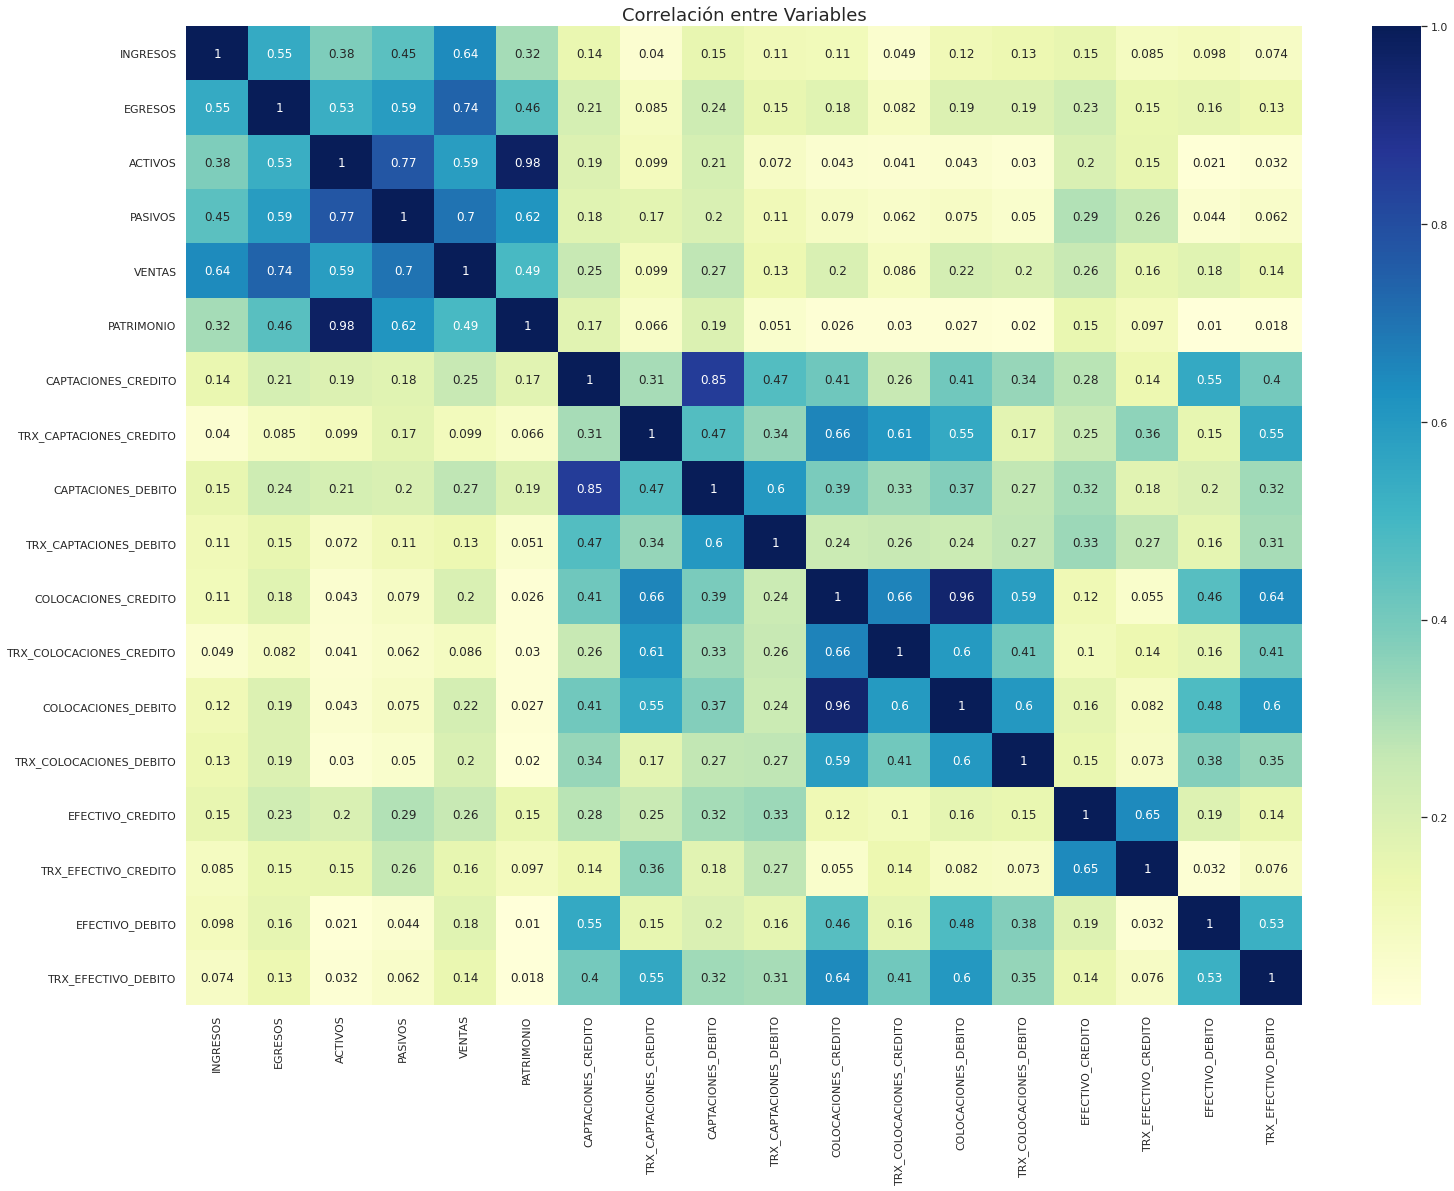

In [ ]:
plt.figure(figsize=(25,18))
ax=sns.heatmap(correlacion,annot=True, fmt=".2g",cmap="YlGnBu")
ax.set_title('Correlación entre Variables',fontsize=18)

### 4.1 Revisión de variables altamente correlacionadas
Dos pares de variables resultaron con una alta correlación, vamos a revisar si existe un motivo que podamos explicar desde la naturaleza de las variables


In [ ]:
main_df[['ACTIVOS','PATRIMONIO']].describe()

,ACTIVOS,PATRIMONIO
count,1.725900e+04,1.725900e+04
mean,1.615833e+09,1.153454e+09
std,4.758443e+10,3.824395e+10
min,0.000000e+00,-9.499096e+10
25%,7.061460e+05,5.117000e+05
50%,5.117000e+06,4.132814e+06
75%,4.093600e+07,3.070200e+07
max,4.208552e+12,3.552196e+12


In [ ]:
main_df[['ACTIVOS','PATRIMONIO']].corr()

,ACTIVOS,PATRIMONIO
ACTIVOS,1.000000,0.975642
PATRIMONIO,0.975642,1.000000


La alta correlación entre ACTIVOS y PATRIMONIO se puede explicar por que el **PATRIMONIO = ACTIVOS - PASIVOS**

* Es ideal que cuando se incluya PATRIMONIO en una permutación NO se incluya ACTIVOS ni PASIVOS

In [ ]:
main_df[['COLOCACIONES_DEBITO','COLOCACIONES_CREDITO']].describe()

,COLOCACIONES_DEBITO,COLOCACIONES_CREDITO
count,1.725900e+04,1.725900e+04
mean,2.146514e+08,1.508971e+08
std,1.049548e+10,7.015694e+09
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,9.599513e+11,6.419369e+11


La alta correlación entre estas variables se debe a que casi todos los datos son 0. Vamos a revisar todo el set de variables relacionadas con montos para descartar aquella que en el 75% aún conserven 0's

In [ ]:
main_df[columns_montos].describe()

,CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,EFECTIVO_CREDITO,EFECTIVO_DEBITO
count,1.725900e+04,1.725900e+04,1.725900e+04,1.725900e+04,1.725900e+04,1.725900e+04
mean,4.369681e+08,2.932586e+08,1.508971e+08,2.146514e+08,4.690864e+07,1.187597e+08
std,5.756687e+09,3.565781e+09,7.015694e+09,1.049548e+10,5.137133e+08,2.439639e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.634288e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.535157e+06,5.296218e+04,0.000000e+00,0.000000e+00,1.023400e+05,1.985396e+06
75%,3.622401e+07,7.816720e+05,0.000000e+00,0.000000e+00,5.941597e+06,2.506307e+07
max,4.617914e+11,2.495395e+11,6.419369e+11,9.599513e+11,2.481354e+10,1.791718e+11


Las variables colocaciones debito y colocaciones credito no aportan mucho valor a los datos.

Se debe considerar una permutacion si estos valores

**Revisemos a continuación la distribución de frecuencias**

In [ ]:
column_frecuencias = ['TRX_CAPTACIONES_CREDITO','TRX_CAPTACIONES_DEBITO','TRX_COLOCACIONES_CREDITO',
'TRX_COLOCACIONES_DEBITO','TRX_EFECTIVO_CREDITO','TRX_EFECTIVO_DEBITO']

In [ ]:
main_df[column_frecuencias].describe()

,TRX_CAPTACIONES_CREDITO,TRX_CAPTACIONES_DEBITO,TRX_COLOCACIONES_CREDITO,TRX_COLOCACIONES_DEBITO,TRX_EFECTIVO_CREDITO,TRX_EFECTIVO_DEBITO
count,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000
mean,250.302625,297.905557,6.032099,0.762964,55.851324,30.603801
std,2656.507355,1347.673751,136.715584,14.033264,511.659551,121.472313
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,26.000000,0.000000,0.000000,1.000000,2.000000
75%,138.000000,148.000000,0.000000,0.000000,9.000000,24.000000
max,318567.000000,56188.000000,10998.000000,1118.000000,34362.000000,8896.000000


Lo mismo sucede con 'TRX_COLOCACIONES_DEBITO',	'TRX_EFECTIVO_CREDITO' 

In [ ]:
main_df

,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,Medio Alto,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
1,Medio Alto,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28
2,Medio Alto,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50
3,Medio Bajo,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
4,Medio Alto,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Bajo,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0
17430,Bajo,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
17431,Medio Alto,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0
17432,Medio Alto,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26


## 5. Codificación riesgo_ciiu

In [ ]:
enc = OrdinalEncoder(categories=[['Bajo', 'Medio Bajo','Medio','Medio Alto','Alto']])

In [ ]:
main_df['RIESGO_CIIU']=enc.fit_transform(main_df[["RIESGO_CIIU"]])

In [ ]:
main_df

,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
1,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28
2,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50
3,1.0,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
4,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,0.0,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0
17430,0.0,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
17431,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0
17432,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26


# Analisis de PCA

In [ ]:
scaler = MinMaxScaler()
norm_series = scaler.fit_transform(main_df)

In [ ]:
norm_df = pd.DataFrame(norm_series, columns=main_df.columns)

In [ ]:
norm_df

,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,0.75,4.366946e-06,0.000000e+00,8.174927e-07,0.000000,5.251355e-08,0.026046,0.000000e+00,0.000006,3.972719e-06,0.001050,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000
1,0.75,6.550418e-07,0.000000e+00,2.436350e-07,0.000000,9.446033e-07,0.026045,2.028542e-05,0.000207,1.811732e-07,0.000997,0.0,0.0,0.0,0.0,0.000007,0.000058,9.481651e-05,0.003147
2,0.75,1.235620e-05,0.000000e+00,4.483836e-06,0.000000,1.485861e-06,0.026050,1.383321e-05,0.001717,5.368411e-08,0.001228,0.0,0.0,0.0,0.0,0.000557,0.002154,2.448587e-04,0.005621
3,0.25,0.000000e+00,0.000000e+00,1.377764e-07,0.000000,0.000000e+00,0.026045,3.427501e-10,0.000044,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000
4,0.75,0.000000e+00,0.000000e+00,1.215858e-06,0.000000,5.251355e-13,0.026046,2.613508e-05,0.000148,5.930736e-05,0.002278,0.0,0.0,0.0,0.0,0.000039,0.000175,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17254,0.00,4.366946e-07,3.280869e-07,2.431716e-07,0.000000,0.000000e+00,0.026045,1.640396e-10,0.000047,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000002,0.000029,0.000000e+00,0.000000
17255,0.00,1.746778e-05,0.000000e+00,1.708037e-08,0.000000,0.000000e+00,0.026045,7.789775e-11,0.000044,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000
17256,0.75,0.000000e+00,0.000000e+00,4.588601e-07,0.000000,5.251355e-08,0.026046,1.573371e-04,0.000917,3.659824e-04,0.006621,0.0,0.0,0.0,0.0,0.000489,0.000960,0.000000e+00,0.000000
17257,0.75,2.183473e-06,0.000000e+00,1.215858e-07,0.000000,5.251355e-08,0.026045,2.202780e-05,0.000057,2.473766e-07,0.000623,0.0,0.0,0.0,0.0,0.000003,0.000029,7.596744e-05,0.002923


In [ ]:
# Gráfica de la varianza explicada acumulada.

def cumulative_explained_variance_plot(expl_variance):

  cum_var_exp = np.cumsum(expl_variance)

  plt.figure(dpi = 100, figsize = (8, 6))
  plt.title('Curva acumulativa de la varianza explicada VS n° de componentes principales')
  plt.xlabel('Número de componentes principales')
  plt.ylabel('Varianza explicada acumulativa')  

  nc = np.arange(1, expl_variance.shape[0] + 1)

  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'c*', ms = 5)   
  plt.show()

### 5.1 PCA del dataset completo

[0.96477387 0.97662903 0.98198451 0.98643864 0.99002907 0.99204077
 0.993717   0.99507361 0.99623147 0.99720868 0.99789262 0.99851312
 0.999013   0.99948262 0.99969645 0.99988656 0.99996779 1.
 1.        ]


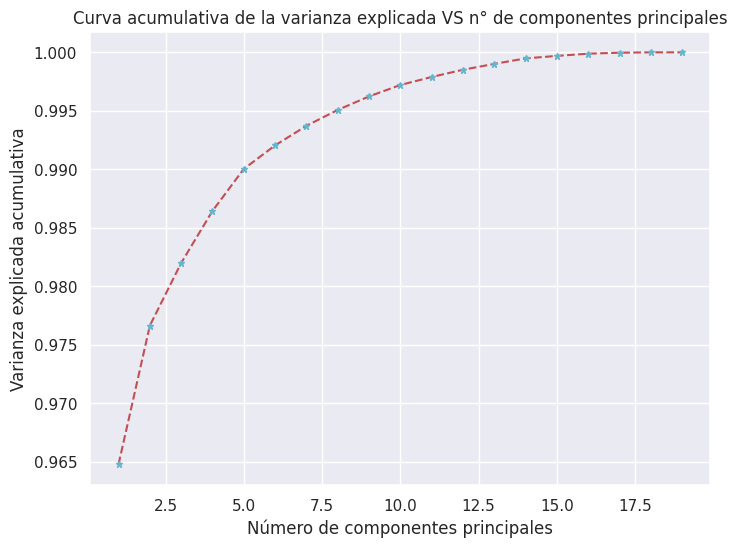

In [ ]:
pca = PCA() 
transf = pca.fit_transform(norm_df)
varianza_expl = pca.explained_variance_ratio_#varianza explicada
cum_var_exp = np.cumsum(varianza_expl)
print(cum_var_exp)
cumulative_explained_variance_plot(varianza_expl)

**Segun los resultados con 2 componentes ya explicamos el 97,6% de los datos**

#### 5.1.1 Visualizacion 2 PCA

In [ ]:
pca = PCA(n_components=2)
X_transf = pca.fit_transform(norm_df)#dos puntos que se pueden representar en X,Y
df_pca_2 = pd.DataFrame(X_transf, columns=['X','Y'])

In [ ]:
df_pca_2

,X,Y
0,-0.169848,-0.005511
1,-0.169846,-0.004772
2,-0.169846,-0.003186
3,0.330149,-0.006742
4,-0.169846,-0.004724
...,...,...
17254,0.580148,-0.007058
17255,0.580148,-0.007063
17256,-0.169839,-0.001698
17257,-0.169847,-0.005065


Segun los resultados obtenidos solo 2 componentes ya explican el cum_var_exp

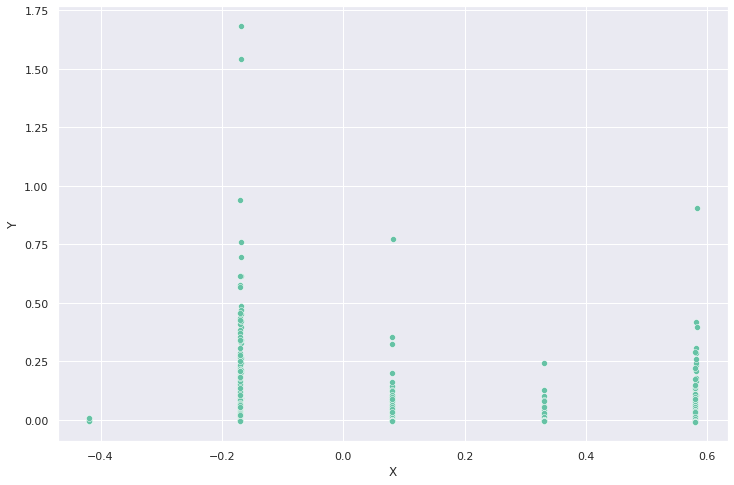

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_pca_2,
                x='X',
                y='Y')          # Variable del eje Y   

Los puntos se ven muy bien distribuidos en el gráfico indicando 5 agrupaciones

### 5.2 PCA de Montos 

[0.4829724  0.746419   0.89039515 0.98732136 0.99584258 1.        ]


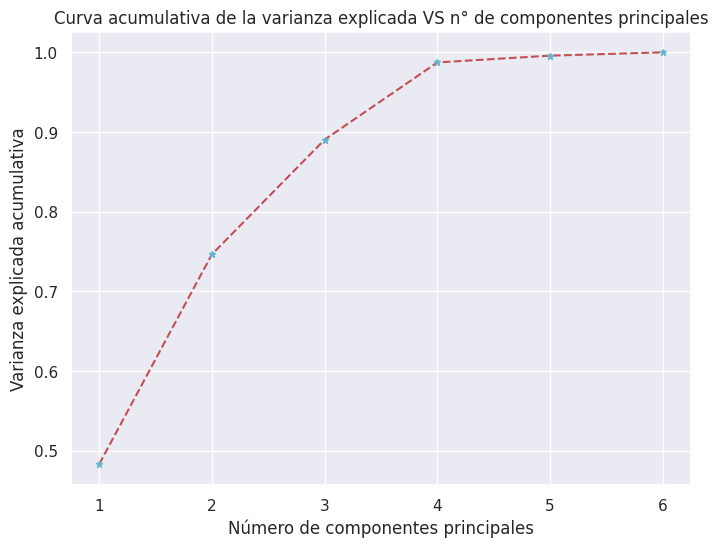

In [ ]:
pca = PCA() 
transf = pca.fit_transform(norm_df[columns_montos])
varianza_expl = pca.explained_variance_ratio_#varianza explicada
cum_var_exp = np.cumsum(varianza_expl)
print(cum_var_exp)
cumulative_explained_variance_plot(varianza_expl)

PCA no se comporta bien cuando se busca reducir la dimensionalidad solo de las variables de montos.

Lo ideal es tener solo 1 PCA para estas variables de montos pero solo logra explicar el 48% de los datos

**se descarta una permutacion con PCA solo de montos**

### 5.3 PCA de frecuencias

[0.50000745 0.67835972 0.82737836 0.9140931  0.9829121  1.        ]


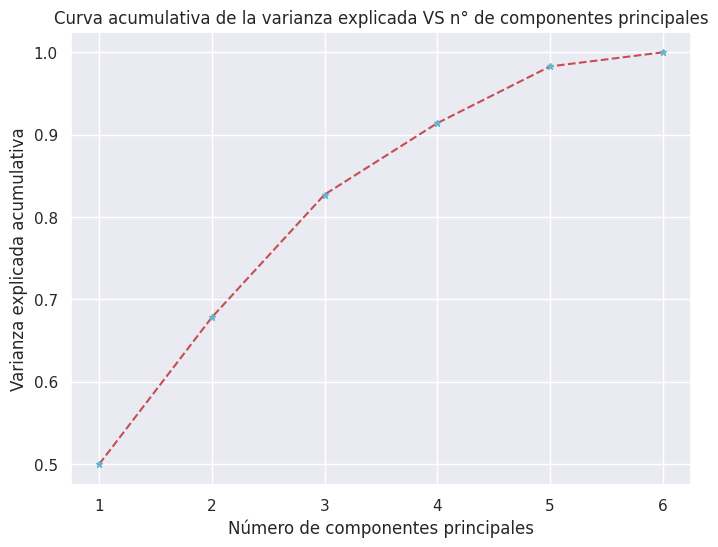

In [ ]:
pca = PCA() 
transf = pca.fit_transform(norm_df[column_frecuencias])
varianza_expl = pca.explained_variance_ratio_#varianza explicada
cum_var_exp = np.cumsum(varianza_expl)
print(cum_var_exp)
cumulative_explained_variance_plot(varianza_expl)

PCA no se comporta tampoco bien cuando se busca reducir la dimensionalidad solo de las variables de frecuencias.

Lo ideal es tener solo 1 PCA para estas variables de frecuencias pero solo logra explicar el 50% de los datos

**se descarta una permutacion con PCA solo de frecuencias**

### 5.3 PCA de montos y frecuencias

In [ ]:
columns_monto_freq = columns_montos + column_frecuencias
columns_monto_freq

['CAPTACIONES_CREDITO',
 'CAPTACIONES_DEBITO',
 'COLOCACIONES_CREDITO',
 'COLOCACIONES_DEBITO',
 'EFECTIVO_CREDITO',
 'EFECTIVO_DEBITO',
 'TRX_CAPTACIONES_CREDITO',
 'TRX_CAPTACIONES_DEBITO',
 'TRX_COLOCACIONES_CREDITO',
 'TRX_COLOCACIONES_DEBITO',
 'TRX_EFECTIVO_CREDITO',
 'TRX_EFECTIVO_DEBITO']

[0.41128976 0.59161279 0.72968662 0.80368119 0.86209353 0.90941655
 0.94500129 0.96976177 0.98816618 0.99561074 0.99880716 1.        ]


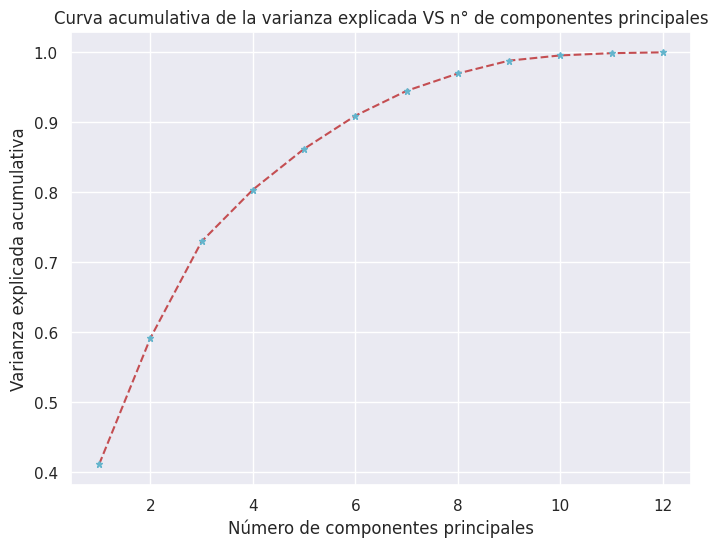

In [ ]:
pca = PCA() 
transf = pca.fit_transform(norm_df[columns_monto_freq])
varianza_expl = pca.explained_variance_ratio_#varianza explicada
cum_var_exp = np.cumsum(varianza_expl)
print(cum_var_exp)
cumulative_explained_variance_plot(varianza_expl)

La combinación de ambos grupos de variables tampoco arroja un porcentaje de varianza acumulada explicada considerable.

# Conclusiones
De acuerdo con los resultados del análisis de correlación y el análisis de componentes principales se definen las siguientes permutaciones a probar:
 
- **perm_1** con 3 PCA que explican el 98% de la variabilidad de los datos e incluye todas las variables del dataset limpio
- **perm_2** dataset sin PCA sin activos, sin pasivos y sin frecuencias
- **perm_3** sin PCA, sin patrimonio y sin columnas: TRX_COLOCACIONES_CREDITO	TRX_COLOCACIONES_DEBITO,'COLOCACIONES_DEBITO','COLOCACIONES_CREDITO' debido a su alta concentración de 0’s

En el siguiente notebook se entrenaran diferentes modelos de clustering y se elegirán los mejores para presentar al cliente